# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [3]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [4]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(8)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
619,4532,49484,? No DMs; contact Me here ?,17-03-2020,If you re struggling to buy food and general s...,Extremely Negative
9896,15816,60768,NaN,20-03-2020,Strange times: When youÃÂre at the grocery s...,Negative
12596,19069,64021,"Kolkata , India",22-03-2020,FMCG makers reduce sanitiser prices amidst cov...,Negative
18515,26331,71283,NaN,25-03-2020,3 Food Delivery Stocks Set To Gain As COVID-19...,Extremely Positive
27898,38004,82956,Southern California,08-04-2020,CarOffer Brings Powerful New Consumer Acquisit...,Positive
9507,15344,60296,NaN,20-03-2020,When all this shit is over and done... remembe...,Negative
15898,23131,68083,"Edmond, OK",24-03-2020,Citizen centric bank allowing consumer borrowe...,Negative
32050,43229,88181,Australia,12-04-2020,Today I bought petrol (gas) for my car $1.04 a...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [5]:
def bin(n):
  if n == 'Positive' or n == 'Extremely Positive':
    return 1
  elif n == 'Negative' or n == 'Extremely Negative':
    return 0


df['Sentiment'] = df['Sentiment'].apply(bin)

df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


In [6]:
df['Sentiment'].unique()

array([1, 0])

// просто проверила, что нет каких-то других значений

Сбалансированы ли классы?

In [7]:
 balanss = df['Sentiment'].value_counts()
 print(balanss / balanss.sum() * 100)

Sentiment
1    53.958857
0    46.041143
Name: count, dtype: float64


**Ответ:** классы составляют 54 и 46 %, разница в 8 процентов, а значит они сбалансированы, но преобладают положительные оценки

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [8]:
df.isnull().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


есть пропуски в локациях

In [9]:
df.fillna('Unknown', inplace=True)
df.isnull().sum().sum()

np.int64(0)

теперь пропусков нет

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [14]:
from collections import Counter

def tokenization(n):
  return n.lower().split()

tweets = train["OriginalTweet"]
tokens = sum(tweets.apply(tokenization), [])
token_freq = Counter(tokens)
token_freq


Counter({'why': 654,
         'we': 3787,
         'still': 763,
         'want': 487,
         'to': 23373,
         'buy': 748,
         'so': 1837,
         'much': 482,
         'stuff': 106,
         'during': 1908,
         'quarantine': 154,
         'https://t.co/1m881cwfuv': 1,
         '#shopping': 121,
         '#covid_19': 1660,
         '#online': 40,
         'with': 4063,
         'driving': 77,
         'even': 682,
         'more': 2008,
         'usage': 22,
         'a': 11737,
         'strong': 93,
         'strategy': 33,
         'is': 7383,
         'critical': 156,
         'now': 1349,
         'then': 435,
         'ever': 179,
         'luckily': 8,
         'and': 14684,
         'april': 163,
         '16': 36,
         'webinar': 65,
         'will': 2726,
         'dive': 10,
         'into': 666,
         'growing': 84,
         'app': 52,
         'awareness': 32,
         'targeting': 9,
         'high': 408,
         'lifetime': 4,
         'value': 

Какой размер словаря получился?

In [15]:
size = len(token_freq)
size

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [16]:
token_freq.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Основные самые пополярные слова - артикли, предлоги и формы глагола to be. Они используются во множестве конструкций в английском языке, служат для связи слов, поэтому они такие популярные. Также популярным словом является #coronavirus, так как это тема твитов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

dt = pd.DataFrame.from_dict(token_freq, orient='index', columns=['count'])
dt = dt.reset_index().rename(columns={'index': 'token'})
stop_words = set(stopwords.words('english'))
dt = dt[~dt['token'].isin(stop_words)]
dt.nlargest(10, 'count')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,token,count
69,#coronavirus,8223
432,prices,3891
99,food,3820
85,grocery,3469
202,supermarket,3288
91,people,3175
144,covid-19,3173
183,store,3155
198,#covid19,2471
636,&amp;,2314


**Ответ:**  Теперь наиболее популярными словами стали слова непосредственно связанные с коронавирусом: #coronavirus, #covid19, covid-19. Также популярны слова связанные с важными темами во время пандемии: еда (food, grocery), цены (prices), супермаркеты, магазины, люди. &amp - преобразование символа & в HTML-сущность для корректного отображения.



Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [26]:
dt.nsmallest(20, 'count')


,token,count
11,https://t.co/1m881cwfuv,1
48,happy..,1
53,https://t.co/z0intks34x,1
67,mnuchinãâs,1
82,brink.,1
95,https://t.co/jmobv8z0u0,1
98,university's,1
117,teaching.),1
121,@catholicpres,1
122,@catholicuniv,1


**Ответ:** Эти токены представленны ссылками, хештегами и словами, слабо связанными с темой твитов. Также у некоторых слов присутствуют дополнительные символы по типу точек, скобочек. Эти слова встречаются единожды и вряд ли так сильно влияют на эмоциональную окраску твита.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [27]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()

tw_tokens = sum(tweets.apply(tw.tokenize), [])
tw_freq = Counter(tw_tokens)
tw_freq.most_common(10)


[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

**Ответ:** Теперь в топе появились знаки препиная (помимо предлогов и артиклей).

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [28]:
from string import punctuation
punct_set = set(punctuation)

tw = TweetTokenizer()
dtw = pd.DataFrame.from_dict(tw_freq, orient='index', columns=['count'])
dtw = dtw.reset_index().rename(columns={'index': 'token'})
stop_words = set(stopwords.words('english'))
deleted_words = punct_set | stop_words
dtw = dtw[~dtw['token'].isin(deleted_words)]
dtw.nlargest(10, 'count')

,token,count
74,Â,7415
73,,7311
161,19,7167
78,#coronavirus,7143
45,I,5235
75,,4372
452,prices,4281
159,COVID,4218
112,food,3795
95,store,3691


**Ответ:** Тут в топе есть как и раннее рассмотренные слова, так и некоторые новые: 19, I. Есть также непонятные слова.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [30]:
filtered_dtw = dtw[(dtw['token'].str.len() > 1) | (dtw['token'].str.len() == 1) & (dtw['token'].str[0].apply(ord) < 128)]
print(filtered_dtw.nlargest(10, 'count'))
print(filtered_dtw.nsmallest(20, 'count'))

            token  count
161            19   7167
78   #coronavirus   7143
45              I   5235
452        prices   4281
159         COVID   4218
112          food   3795
95          store   3691
223   supermarket   3373
94        grocery   3083
101        people   3047
                       token  count
11   https://t.co/1m881CwFUv      1
54   https://t.co/Z0intkS34x      1
72                  MnuchinÃ      1
107  https://t.co/JmoBv8z0U0      1
111             University's      1
136            @CatholicPres      1
137            @CatholicUniv      1
138  https://t.co/EvQby035wF      1
163  https://t.co/rIQrhxxeIM      1
166          @BallardSpahrLL      1
167                #training      1
168                     #aca      1
232  https://t.co/0FmSmlGePM      1
246                 Irishman      1
250      #HappyStPatricksDay      1
254                  Guiness      1
314  https://t.co/18V0PYHwb7      1
328  https://t.co/LS0g86i8PU      1
329  https://t.co/oFVkejfF23      1
344  

**Ответ:** В целом топы схожи, но в топе наименее популярных слов меньше слов со случайными символами (точкой, скобкой), это уменьшает вероятность выбросов обычных слов (если рядом случайно поставили какой-то знак).

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [31]:
hashtags = filtered_dtw[filtered_dtw['token'].str.startswith('#')]
hashtags.nlargest(10, 'count')

,token,count
78,#coronavirus,7143
218,#COVID19,1844
13,#Covid_19,1463
219,#Coronavirus,1281
926,#COVID2019,927
148,#toiletpaper,657
1420,#covid19,568
1068,#COVID,542
194,#CoronaCrisis,426
2659,#CoronaVirus,351


**Ответ:** Большинство хештегов связаны с оновной темой твитов - коронавирусом. Есть хештег связанный с туалетной бумагой, проблема с доступностью которой поднималась во время пандемии.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [32]:
links = filtered_dtw[filtered_dtw['token'].str.startswith('https://t.co')]
links.nlargest(10, 'count')

,token,count
18862,https://t.co/oXA7SWtoNd,5
2598,https://t.co/gP3EusapL8,4
7662,https://t.co/DefTruI1PfÃÂ,3
10290,https://t.co/WrLHYzIzAA,3
10476,https://t.co/kuwIpF1KQW,3
11936,https://t.co/zjNRx6dKKN,3
13959,https://t.co/3GBBDpdjat,3
16151,https://t.co/e2ZNXajPre,3
26644,https://t.co/CATKegAyOY,3
28042,https://t.co/G63RP042HO,3


**Ответ:** Хештеги значительно популярнее ссылок. В связи с этим информация о ссылке будет не такой полезной.



Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [33]:
def custom_tokenizer(text):
  text = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(text)
  filtered_tokens = []

  stop_words = set(stopwords.words('english'))
  punct_set = set(punctuation)

  for token in tokens:
    if token in stop_words:
      continue
    if token in punct_set:
      continue
    if token.startswith(('http://t.co', 'https://t.co')):
      continue
    if len(token) == 1 and ord(token) >= 128:
      continue
    filtered_tokens.append(token)

  return filtered_tokens


In [34]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

45290


**Ответ:** Словарь сильно меньше (чуть меньше, чем в два раза). Это связано с обработкой и удалением невалидных слов: стоп-слов, ссылок, нечитаемых символов.



Посмотрим на какой-нибудь конкретный твитт:

In [37]:
ind = 9023
tweet = train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']
tweet

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [39]:
vector = cv.transform([tweet[0]])
print(vector)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 14 stored elements and shape (1, 45290)>
  Coords	Values
  (0, 1833)	1
  (0, 2046)	1
  (0, 16658)	1
  (0, 20553)	1
  (0, 26665)	1
  (0, 27042)	1
  (0, 27233)	1
  (0, 31570)	1
  (0, 34070)	1
  (0, 34679)	1
  (0, 35248)	1
  (0, 36404)	1
  (0, 37220)	1
  (0, 39909)	1


**Ответ:** Токены встречаются единожды, поэтому не получится определить.



Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv.fit(train['OriginalTweet'])
tv_vector = tv.transform([tweet[0]])
print(tv_vector)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14 stored elements and shape (1, 45290)>
  Coords	Values
  (0, 1833)	0.22584265007428544
  (0, 2046)	0.16825192939361902
  (0, 16658)	0.31042634466284263
  (0, 20553)	0.3867641170466375
  (0, 26665)	0.3244741764513268
  (0, 27042)	0.11328893069250721
  (0, 27233)	0.32047314046539654
  (0, 31570)	0.30121070136861045
  (0, 34070)	0.2542729176022132
  (0, 34679)	0.16306722855395073
  (0, 35248)	0.14759470306326164
  (0, 36404)	0.2550064610386691
  (0, 37220)	0.35434556333216544
  (0, 39909)	0.24406492401820118


In [41]:
tv_array = tv_vector.toarray()[0]
inv_v = {i: word for word, i in tv.vocabulary_.items()}

non_zero_ids = np.where(tv_array > 0)[0]
if len(non_zero_ids) > 0:
    max_id = tv_array.argmax()
    most = inv_v[max_id]
    most_score = tv_array[max_id]
    min_id = non_zero_ids[tv_array[non_zero_ids].argmin()]
    least = inv_v[min_id]
    least_score = tv_array[min_id]
else:
    most = None
    most_score = None
    least = None
    least_score = None
print(f"Самый важный токен: '{most}' (вес: {most_score:0.4f})")
print(f"Самый неважный токен: '{least}' (вес: {least_score:0.4f})")

Самый важный токен: 'brainless' (вес: 0.3868)
Самый неважный токен: 'food' (вес: 0.1133)


**Ответ:** Токены неплохо определились, это происходит из-за грамотной обработки частот и статистики.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [42]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",1
20314,28576,73528,"New Delhi, India",27-03-2020,India on lockdown...I'm more worried by death ...,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
5140,10048,55000,New Zealand,19-03-2020,Countdown supermarket limiting some goods: You...,1
19139,27090,72042,Unknown,25-03-2020,@MorganRadford good segment! BTW where did yo...,1
...,...,...,...,...,...,...
19361,27366,72318,Unknown,26-03-2020,@jichiemin LetÃÂs hope it not #coronavirus ?...,1
6250,11382,56334,"Mumbai, India",19-03-2020,Respected Sir @narendramodi \r\r\n\r\r\nWe und...,1
15997,23260,68212,sales@esmmagazine.com,24-03-2020,#Consumer goods giant @Unilever Plc said on Tu...,1
18819,26706,71658,"Chicago, IL",25-03-2020,Online grocery shopping? Here are some good ti...,1


In [47]:
good_text = train.loc[15997]['OriginalTweet']
good_text

'#Consumer goods giant @Unilever Plc said on Tuesday it would protect its workforce from the financial impact of the #coronavirus by continuing to pay contractors and other part time staff for up to three months. https://t.co/Iqq3mc52vF'

In [48]:
tv_good_tweet = tv.transform([good_text])
features = tv.get_feature_names_out()

values = tv_good_tweet.toarray().flatten()

sorted_by_values = sorted(zip(features, values), key=lambda x: -x[1])

print("Слова, отсортированные по TF-IDF:")
for word, value in sorted_by_values:
    if value > 0:
        print(f"{word}: {value:0.4f}")

Слова, отсортированные по TF-IDF:
plc: 0.3317
contractors: 0.3241
@unilever: 0.3125
workforce: 0.2650
continuing: 0.2564
tuesday: 0.2465
giant: 0.2261
#consumer: 0.2238
three: 0.2143
months: 0.2003
financial: 0.1939
part: 0.1913
goods: 0.1861
protect: 0.1802
pay: 0.1771
said: 0.1722
impact: 0.1705
staff: 0.1598
would: 0.1558
time: 0.1321
#coronavirus: 0.0680


**Ответ:** Твит повествует о продолжении выплат. О положительном ключе говорят слова: continuing, protect и слова связанные с профессиями.Проблема работы и выплат во время пандемии стояла довольно остро, поэтому эти слова довольно существены и часто встречаются в текстах.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y = df['Sentiment']
X = df['OriginalTweet']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52, stratify=y)


cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)

X_train_cv = cv.fit_transform(X_train)
X_train_tv = tv.fit_transform(X_train)

X_test_cv = cv.transform(X_test)
X_test_tv = tv.transform(X_test)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [54]:
cvlr = LogisticRegression(max_iter=1000)
tvlr = LogisticRegression(max_iter=1000)

cvlr.fit(X_train_cv, y_train)
tvlr.fit(X_train_tv, y_train)

y_train_cv_predict = cvlr.predict(X_train_cv)
y_test_cv_predict = cvlr.predict(X_test_cv)

y_train_tv_predict = tvlr.predict(X_train_tv)
y_test_tv_predict = tvlr.predict(X_test_tv)
print("CountVectorizer:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_cv_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_cv_predict):0.4f}\n")
print("TF-IDF:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_tv_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_tv_predict):0.4f}")




CountVectorizer:
Train Accuracy: 0.9838
Test Accuracy:  0.8672

TF-IDF:
Train Accuracy: 0.9272
Test Accuracy:  0.8476


**Ответ:** CountVectorizer оказалась точнее (хотя для твитов можно было ожидать другого результата).

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [55]:
from nltk.stem import SnowballStemmer


def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  text = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(text)
  filtered_tokens = []

  stop_words = set(stopwords.words('english'))
  punct_set = set(punctuation)

  for token in tokens:
    if token in stop_words:
      continue
    if token in punct_set:
      continue
    if token.startswith(('http://t.co', 'https://t.co')):
      continue
    if len(token) == 1 and ord(token) >= 128:
      continue
    filtered_tokens.append(token)
    stemmed_tokens = [stemmer.stem(w) for w in filtered_tokens]

  return stemmed_tokens

In [56]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [57]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)

X_train_cv = cv.fit_transform(X_train)
X_train_tv = tv.fit_transform(X_train)

print(len(cv.vocabulary_))
print(len(tv.vocabulary_))

36752
36752


**Ответ** Словарь уменьшился за счёт уменьшения количества форм слов.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [58]:
X_test_cv = cv.transform(X_test)
X_test_tv = tv.transform(X_test)

cvlr.fit(X_train_cv, y_train)
tvlr.fit(X_train_tv, y_train)

y_train_cv_predict = cvlr.predict(X_train_cv)
y_test_cv_predict = cvlr.predict(X_test_cv)

y_train_tv_predict = tvlr.predict(X_train_tv)
y_test_tv_predict = tvlr.predict(X_test_tv)
print("CountVectorizer:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_cv_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_cv_predict):0.4f}\n")
print("TF-IDF:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_tv_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_tv_predict):0.4f}")


CountVectorizer:
Train Accuracy: 0.9707
Test Accuracy:  0.8644

TF-IDF:
Train Accuracy: 0.9169
Test Accuracy:  0.8524


**Ответ:** # Качество изменилось не сильно (только у второй модели немного повысилось на тестовой выборке). Стемминг стоит применять при большом количестве словоформ. Но он всё же способствует уменьшению вичислительных затрат, уменьшению разреженности для редких слов.



## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [62]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None).fit(X_train)
X = cv.transform(X_train)
freq = (X > 0).mean(axis=0).A.ravel()
sorted_freqs = np.sort(freq)[::-1]
if len(sorted_freqs) > 1:
    max_df = sorted_freqs[1]
else:
    max_df = 1

cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df, token_pattern=None).fit(X_train)
print(len(cv_df.vocabulary_))

36751


**Ответ:** Словарь уменьшился на 1.Максимальное значение взято по частоте второго по популярности токена.





Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [65]:
df2 = pd.DataFrame({
    "token": cv.get_feature_names_out(),
    "freq": freq
})

df2_sorted = df2.sort_values(by="freq", ascending=False).reset_index(drop=True)

min_df = df2_sorted.loc[3699, "freq"]

cv_min_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df, token_pattern=None).fit(X_train)
print(min_df)
print(len(cv_min_df.vocabulary_))

0.00042716787697565144
3905


In [66]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cvlr = LogisticRegression(max_iter=1000)

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
cvlr.fit(X_train_cv, y_train)

y_train_cv_predict = cvlr.predict(X_train_cv)
y_test_cv_predict = cvlr.predict(X_test_cv)

print("CountVectorizer:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_cv_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_cv_predict):0.4f}\n")



CountVectorizer:
Train Accuracy: 0.9707
Test Accuracy:  0.8644



In [67]:
cvlr = LogisticRegression(max_iter=1000)

X_train_min_df = cv_min_df.fit_transform(X_train)
X_test_min_df = cv_min_df.transform(X_test)
cvlr.fit(X_train_min_df, y_train)

y_train_min_predict = cvlr.predict(X_train_min_df)
y_test_min_predict = cvlr.predict(X_test_min_df)

print("CountVectorizer:")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_min_predict):0.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_min_predict):0.4f}\n")



CountVectorizer:
Train Accuracy: 0.9321
Test Accuracy:  0.8604



**Ответ:** Сокращение словаря понизило качество, но не сильно (но на тренировочной выборке сильнее).

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

Train Accuracy: 0.9444254592054677
Test Accuracy:  0.8387482559298386


<ipython-input-71-a3e7ca0733ba>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=w[positives], y=features[positives], palette='magma')
<ipython-input-71-a3e7ca0733ba>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=w[negatives], y=features[negatives], palette='magma')


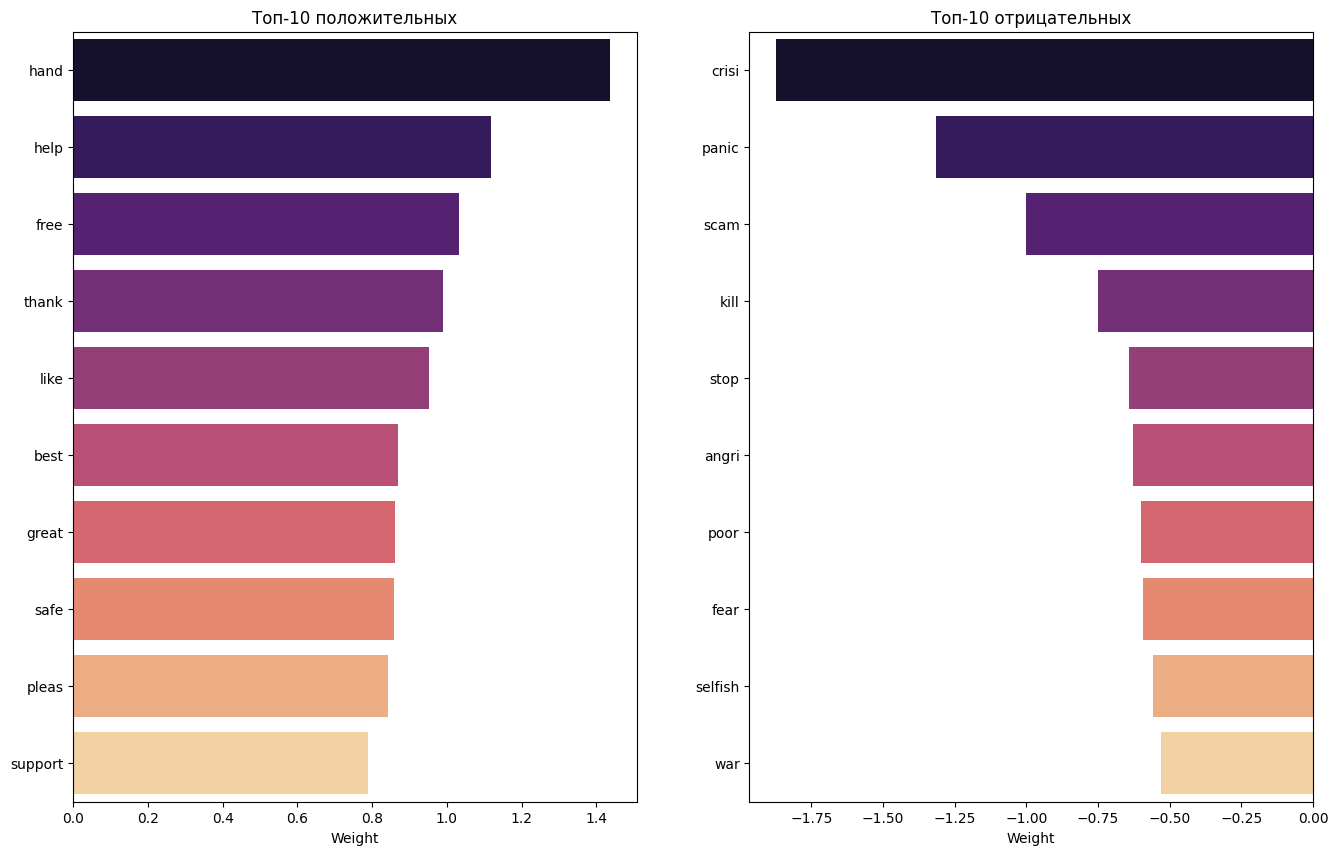

In [71]:
from sklearn.preprocessing import StandardScaler
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, max_features=3700, token_pattern=None)

X_train_array = cv.fit_transform(X_train).toarray()
X_test_array = cv.transform(X_test).toarray()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_array)
X_test_scaled = scaler.transform(X_test_array)

cvlr = LogisticRegression(max_iter=1000)
cvlr.fit(X_train_scaled, y_train)

print("Train Accuracy:", accuracy_score(y_train, cvlr.predict(X_train_scaled)))
print("Test Accuracy: ", accuracy_score(y_test, cvlr.predict(X_test_scaled)))

features = cv.get_feature_names_out()
w = cvlr.coef_[0]

positives = np.argsort(w)[-10::][::-1]
negatives = np.argsort(w)[:10]

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=w[positives], y=features[positives], palette='magma')
plt.title('Топ-10 положительных')
plt.xlabel('Weight')

plt.subplot(1, 2, 2)
sns.barplot(x=w[negatives], y=features[negatives], palette='magma')
plt.title('Топ-10 отрицательных')
plt.xlabel('Weight')

plt.show()




**Ответ:** Видно разделение токенов на положительные и отрицательные.



## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** # -- YOUR ANSWER HERE --

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
# -- YOUR CODE HERE --

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [ ]:
# -- YOUR CODE HERE --

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
# -- YOUR CODE HERE --

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --